# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

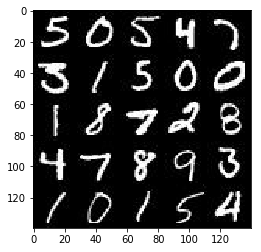

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

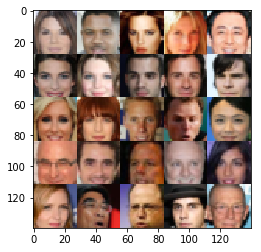

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    return (
        tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real'), 
        tf.placeholder(tf.float32, (None, z_dim), name='input_z'), 
        tf.placeholder(tf.float32, shape=None, name='learning_rate')
    )

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1, std=0.02):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                             kernel_initializer=tf.random_normal_initializer(stddev=std))
        relu1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', 
                             kernel_initializer=tf.random_normal_initializer(stddev=std))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', 
                             kernel_initializer=tf.random_normal_initializer(stddev=std))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, 
                                kernel_initializer=tf.random_normal_initializer(stddev=std))
        out = tf.sigmoid(logits)
        
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, reuse=None, alpha=0.1, std=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):

        x1 = tf.layers.dense(z, 7*7*256)

        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', 
                                       kernel_initializer=tf.random_normal_initializer(stddev=std))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', 
                                       kernel_initializer=tf.random_normal_initializer(stddev=std))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same', 
                                           kernel_initializer=tf.random_normal_initializer(stddev=std))

        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                           labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                           labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    all_updates = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [var for var in all_updates if var.name.startswith('discriminator')]
    g_updates = [var for var in all_updates if var.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    width, height, channel = data_shape[1], data_shape[2], data_shape[3]
    
    input_real, input_z, learn_rate = model_inputs(width, height, channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, 
                             feed_dict={input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, channel, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 3.1538
Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.6332
Epoch 1/2... Discriminator Loss: 0.7250... Generator Loss: 1.4876
Epoch 1/2... Discriminator Loss: 1.6389... Generator Loss: 1.6493
Epoch 1/2... Discriminator Loss: 1.7878... Generator Loss: 0.4201
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 1.3708
Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.6205
Epoch 1/2... Discriminator Loss: 1.6454... Generator Loss: 0.3992
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 0.8295
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.5904


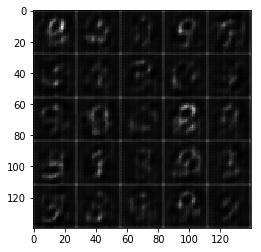

Epoch 1/2... Discriminator Loss: 1.3986... Generator Loss: 1.9628
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 1.3221
Epoch 1/2... Discriminator Loss: 1.6435... Generator Loss: 0.4133
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 1.0471
Epoch 1/2... Discriminator Loss: 1.2033... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 1.8849... Generator Loss: 2.5930
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 1.3827
Epoch 1/2... Discriminator Loss: 1.7379... Generator Loss: 0.3677
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 0.9986
Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.6083


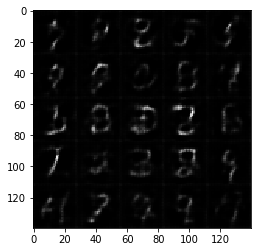

Epoch 1/2... Discriminator Loss: 1.5655... Generator Loss: 0.4089
Epoch 1/2... Discriminator Loss: 1.2691... Generator Loss: 0.9753
Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 1.2992
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 1.0487
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.6772
Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 0.9435
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 1.2125... Generator Loss: 1.1277
Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.4376
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 1.5041


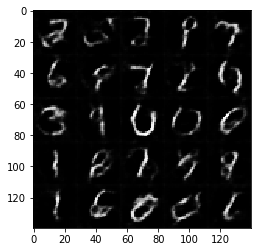

Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 0.6709
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 1.5237
Epoch 1/2... Discriminator Loss: 1.3879... Generator Loss: 0.5575
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.9005
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 1.7248
Epoch 1/2... Discriminator Loss: 1.1120... Generator Loss: 1.1016
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 1.1445
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.6260
Epoch 1/2... Discriminator Loss: 1.2158... Generator Loss: 0.8773
Epoch 1/2... Discriminator Loss: 1.3078... Generator Loss: 0.6056


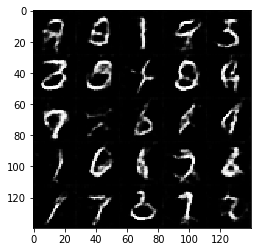

Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 0.9927
Epoch 1/2... Discriminator Loss: 1.5755... Generator Loss: 0.4813
Epoch 1/2... Discriminator Loss: 1.5635... Generator Loss: 0.4067
Epoch 1/2... Discriminator Loss: 1.2027... Generator Loss: 0.7331
Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 0.8625
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 0.9294
Epoch 1/2... Discriminator Loss: 1.1683... Generator Loss: 1.3501
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 1.2350
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.5859
Epoch 1/2... Discriminator Loss: 1.2296... Generator Loss: 0.6890


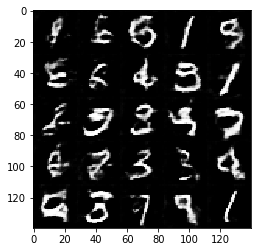

Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 1.2399
Epoch 1/2... Discriminator Loss: 1.5711... Generator Loss: 0.4647
Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 0.5975
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.7781
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 0.8092
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.5775
Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 1.8435... Generator Loss: 0.3069


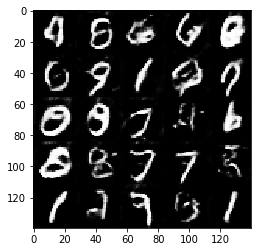

Epoch 1/2... Discriminator Loss: 1.1313... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 1.4436... Generator Loss: 1.6823
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 1.0776
Epoch 1/2... Discriminator Loss: 1.0726... Generator Loss: 1.2233
Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 0.8289
Epoch 1/2... Discriminator Loss: 1.1834... Generator Loss: 0.9976
Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 1.6641
Epoch 1/2... Discriminator Loss: 1.9010... Generator Loss: 2.8941
Epoch 1/2... Discriminator Loss: 1.1927... Generator Loss: 0.7165


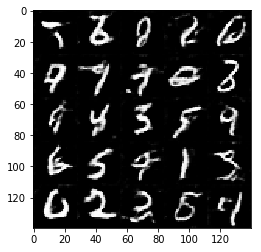

Epoch 1/2... Discriminator Loss: 0.9215... Generator Loss: 1.3100
Epoch 1/2... Discriminator Loss: 1.9000... Generator Loss: 0.2897
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 0.7049
Epoch 1/2... Discriminator Loss: 1.6567... Generator Loss: 0.3864
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.7116
Epoch 1/2... Discriminator Loss: 1.6485... Generator Loss: 0.3988
Epoch 1/2... Discriminator Loss: 1.1694... Generator Loss: 1.3527
Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 1.0538
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.5591


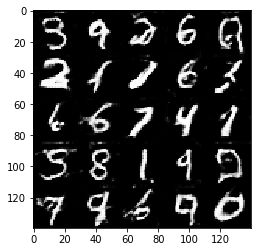

Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 1.5053
Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.8024
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.6353
Epoch 1/2... Discriminator Loss: 1.0040... Generator Loss: 1.3131
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 0.5430
Epoch 1/2... Discriminator Loss: 1.3920... Generator Loss: 0.5272
Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 1.1995
Epoch 1/2... Discriminator Loss: 1.4845... Generator Loss: 0.5157
Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 1.6201


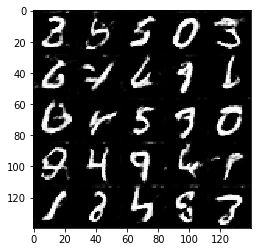

Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 0.9269
Epoch 1/2... Discriminator Loss: 1.5960... Generator Loss: 0.4254
Epoch 1/2... Discriminator Loss: 1.0916... Generator Loss: 1.7525
Epoch 2/2... Discriminator Loss: 1.3921... Generator Loss: 0.5400
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 0.9561... Generator Loss: 1.1964
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 1.9159
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 1.0795... Generator Loss: 1.1813
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.5196


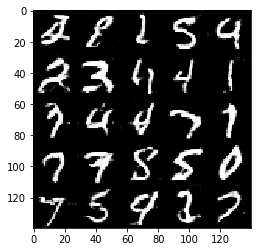

Epoch 2/2... Discriminator Loss: 1.1656... Generator Loss: 2.2243
Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 1.2057
Epoch 2/2... Discriminator Loss: 1.1778... Generator Loss: 0.7602
Epoch 2/2... Discriminator Loss: 1.4519... Generator Loss: 0.4971
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.0911... Generator Loss: 1.5166
Epoch 2/2... Discriminator Loss: 1.4531... Generator Loss: 0.4851
Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 1.8827
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 0.8155
Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 1.1722


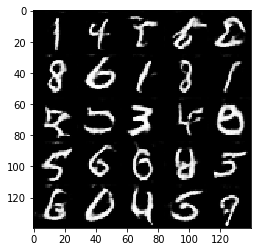

Epoch 2/2... Discriminator Loss: 1.0441... Generator Loss: 1.2081
Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 1.0553
Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 1.0228... Generator Loss: 1.5657
Epoch 2/2... Discriminator Loss: 1.8343... Generator Loss: 0.3290
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 0.7187
Epoch 2/2... Discriminator Loss: 0.9178... Generator Loss: 1.3405
Epoch 2/2... Discriminator Loss: 1.1347... Generator Loss: 0.7585
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 1.5915


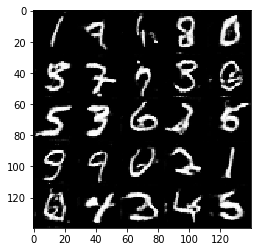

Epoch 2/2... Discriminator Loss: 1.0778... Generator Loss: 0.9424
Epoch 2/2... Discriminator Loss: 1.6093... Generator Loss: 0.3879
Epoch 2/2... Discriminator Loss: 1.4637... Generator Loss: 0.5489
Epoch 2/2... Discriminator Loss: 1.3735... Generator Loss: 0.5444
Epoch 2/2... Discriminator Loss: 1.0572... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.2560... Generator Loss: 0.7052
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 1.4352
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.6604
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.1158... Generator Loss: 0.9164


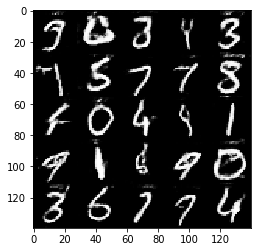

Epoch 2/2... Discriminator Loss: 1.1568... Generator Loss: 0.8913
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 1.0911
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 1.1062... Generator Loss: 1.4723
Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 1.5526
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.5476
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 1.3651
Epoch 2/2... Discriminator Loss: 1.3497... Generator Loss: 1.8665
Epoch 2/2... Discriminator Loss: 1.3010... Generator Loss: 0.6328


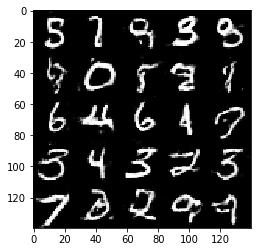

Epoch 2/2... Discriminator Loss: 1.1786... Generator Loss: 1.4832
Epoch 2/2... Discriminator Loss: 1.1685... Generator Loss: 1.7092
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.6246
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 1.0066
Epoch 2/2... Discriminator Loss: 1.1269... Generator Loss: 0.9756
Epoch 2/2... Discriminator Loss: 1.1345... Generator Loss: 0.9801
Epoch 2/2... Discriminator Loss: 1.1267... Generator Loss: 0.8971
Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 1.3274
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 0.7889
Epoch 2/2... Discriminator Loss: 1.3029... Generator Loss: 2.0303


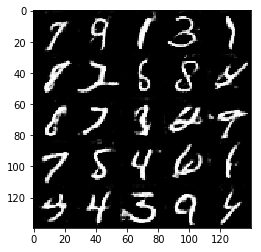

Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 1.0112
Epoch 2/2... Discriminator Loss: 1.5080... Generator Loss: 0.4804
Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 0.9499
Epoch 2/2... Discriminator Loss: 1.0280... Generator Loss: 1.0644
Epoch 2/2... Discriminator Loss: 1.0202... Generator Loss: 1.1498
Epoch 2/2... Discriminator Loss: 1.0964... Generator Loss: 1.6612
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 0.8208
Epoch 2/2... Discriminator Loss: 1.1679... Generator Loss: 1.0340
Epoch 2/2... Discriminator Loss: 1.0286... Generator Loss: 0.9288
Epoch 2/2... Discriminator Loss: 1.0574... Generator Loss: 1.3731


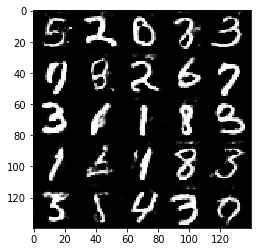

Epoch 2/2... Discriminator Loss: 1.1545... Generator Loss: 0.7062
Epoch 2/2... Discriminator Loss: 0.8564... Generator Loss: 1.6037
Epoch 2/2... Discriminator Loss: 1.6514... Generator Loss: 0.3928
Epoch 2/2... Discriminator Loss: 1.1260... Generator Loss: 1.1554
Epoch 2/2... Discriminator Loss: 1.1503... Generator Loss: 1.0609
Epoch 2/2... Discriminator Loss: 1.0770... Generator Loss: 0.8961
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 1.0896
Epoch 2/2... Discriminator Loss: 1.2028... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.0645... Generator Loss: 1.0785
Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 0.9086


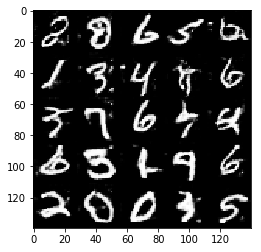

Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.1919
Epoch 2/2... Discriminator Loss: 1.0659... Generator Loss: 1.1045
Epoch 2/2... Discriminator Loss: 1.5602... Generator Loss: 0.4563
Epoch 2/2... Discriminator Loss: 1.5575... Generator Loss: 0.4651
Epoch 2/2... Discriminator Loss: 1.1166... Generator Loss: 1.9590
Epoch 2/2... Discriminator Loss: 1.0776... Generator Loss: 1.5350
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 1.4839
Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.5921
Epoch 2/2... Discriminator Loss: 1.1755... Generator Loss: 1.0544
Epoch 2/2... Discriminator Loss: 1.0127... Generator Loss: 0.9434


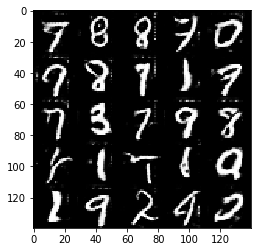

Epoch 2/2... Discriminator Loss: 1.4505... Generator Loss: 0.5072
Epoch 2/2... Discriminator Loss: 1.1276... Generator Loss: 0.7638
Epoch 2/2... Discriminator Loss: 1.2513... Generator Loss: 0.6795
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.5098
Epoch 2/2... Discriminator Loss: 1.0621... Generator Loss: 0.8846
Epoch 2/2... Discriminator Loss: 0.9037... Generator Loss: 1.4905
Epoch 2/2... Discriminator Loss: 1.0884... Generator Loss: 0.9359


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 7.9921
Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 2.2353
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.6436
Epoch 1/1... Discriminator Loss: 1.6425... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 1.4667
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.8228


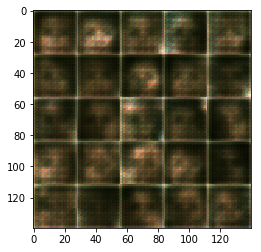

Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 1.9380
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 2.1738... Generator Loss: 2.6409
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.9029


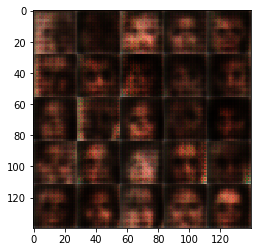

Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.7064... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.9735
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8207
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.7604


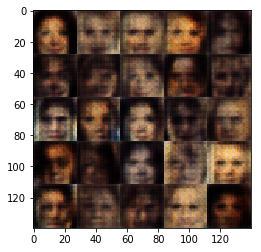

Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.9458
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 1.0016
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.9646


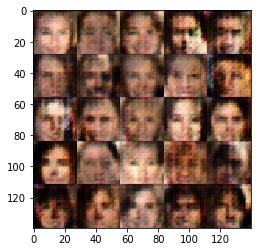

Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.9902
Epoch 1/1... Discriminator Loss: 1.6929... Generator Loss: 0.4483


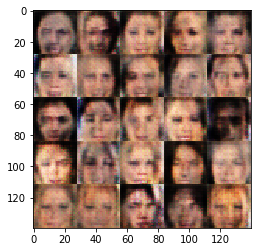

Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.7389... Generator Loss: 0.5216
Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.6531


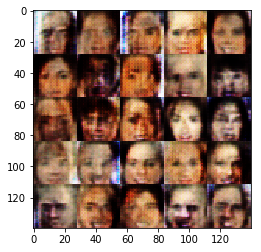

Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.7048... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.9028
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 1.0469
Epoch 1/1... Discriminator Loss: 1.1741... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7999


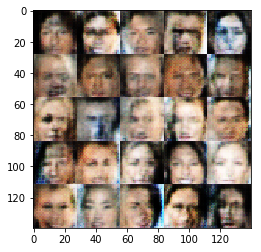

Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.5362
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.9766
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7088


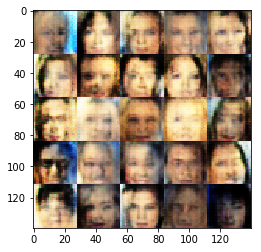

Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.8901
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.9890
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.1912... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.7958


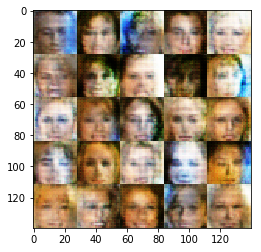

Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8916
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7668


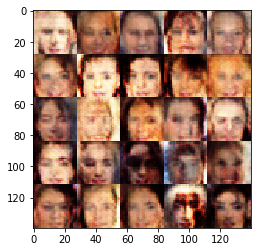

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.4542
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.2326... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.5447


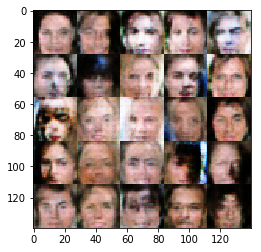

Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.5429
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7712
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.9176


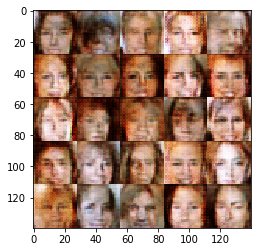

Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.3182... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.9115


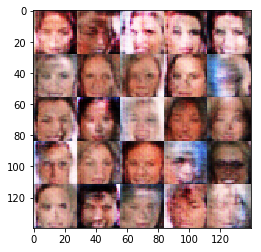

Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.5033
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7841


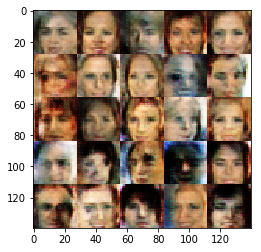

Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 1.0055


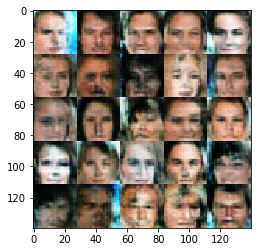

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 1.1352
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 1.0495


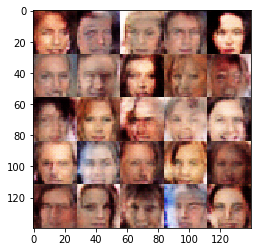

Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 1.2744
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.5146


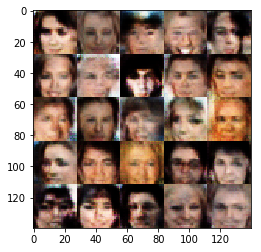

Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.5673


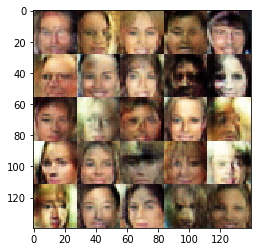

Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 1.0921
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 0.8796


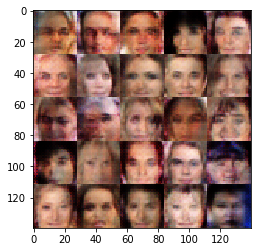

Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 1.2110
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.8076
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8417


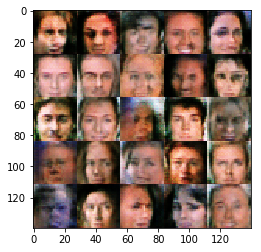

Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.9431


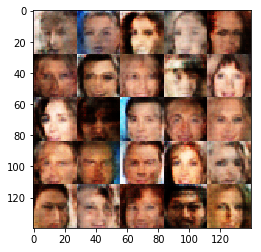

Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.4800
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.8122


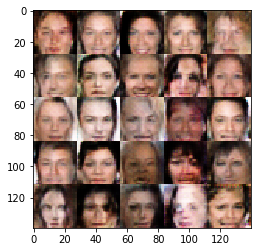

Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 1.2500
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7948


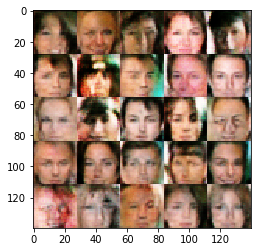

Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 1.2269
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 1.0082
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 1.0576


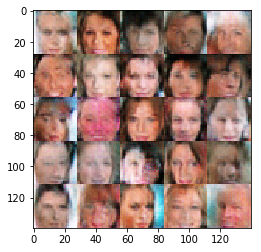

Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.2212
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 1.0265


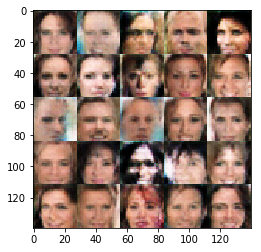

Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 1.0548
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.5078
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.8319


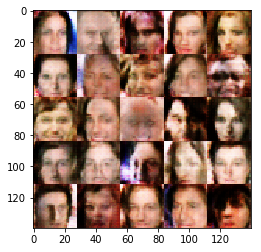

Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 1.1227
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.9286
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.9553


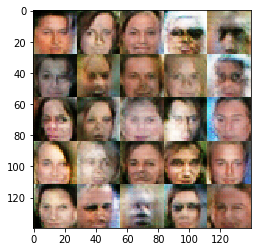

Epoch 1/1... Discriminator Loss: 1.3380... Generator Loss: 1.2187
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8007


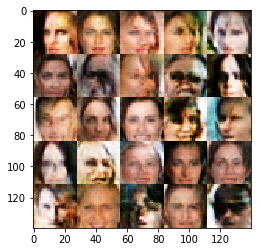

Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 1.0169
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.3225... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.8587


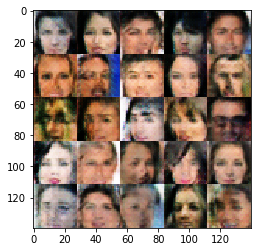

Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.7132


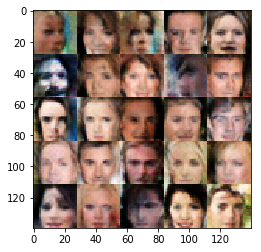

Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7973
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.9528
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.9376


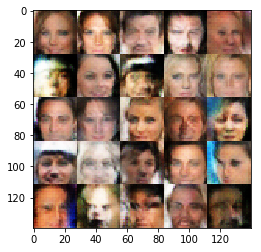

Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.6916


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.